In [36]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from umap import UMAP
import torch
from torch import nn
import optuna
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(0)

cuda


In [78]:
def reload_utils():
    """Reload all utils modules"""
    import utils.data_utils
    import utils.model_utils
    import utils.train_test_utils
    import utils.plot_utils
    
    importlib.reload(utils.data_utils)
    importlib.reload(utils.model_utils)
    importlib.reload(utils.train_test_utils)
    importlib.reload(utils.plot_utils)

reload_utils()

# Import custom modules
from utils.data_utils import (
    construct_loader,
    get_mol_infos,
)
from utils.model_utils import GNN
from utils.train_test_utils import (
    Standardizer,
    train_epoch,
    train_epoch_without_SSL,
    pred,
    pred_with_TTA,
    embeddings_with_TTA,
)
from utils.plot_utils import (
    solubility_histogram,
    atom_count_histogram,
    functional_group_histogram,
    solubility_histogram_shift,
    solubility_embeddings,
    sets_embeddings,
    centroid_embeddings,
)

In [38]:
batch_size = 512
epochs = 20

train_hyperparam_opt = False # Optional optimization of training hyperparameters

# If wanted, we can load an already trained model
save_model = False  # Set to False if you don't want to save
load_trained_model = True  # Set to True to skip training and load existing model
save_plots = False

# Data

### Loading the Data

In [39]:
data_df = pd.read_csv("data/AqSolDBc.csv")
# Drop single atoms
idx_single = [
    i
    for i, s in enumerate(data_df["SmilesCurated"])
    if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or "." in s
]

data_df = data_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

test_df = pd.read_csv("data/OChemUnseen.csv")
# Drop some Nonetypes
# Got an error for a SMILES which was None
idx_nonetype = [
    i for i, s in enumerate(test_df["SMILES"]) if Chem.MolFromSmiles(s) is None
]

test_df = test_df.drop(idx_nonetype)
if len(idx_nonetype) > 0:
    print(f"Removing {idx_nonetype} due to Nonetypes")

# Drop single atoms
idx_single = [
    i
    for i, s in enumerate(test_df["SMILES"])
    if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or "." in s
]

test_df = test_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

# Get additional information on the molecules, such as number of atoms, functional groups
data_df_updated = get_mol_infos(data_df, "SmilesCurated")
test_df_updated = get_mol_infos(test_df, "SMILES")

Removing [1263, 1444, 3605, 3702] due to single atoms


[18:32:46] Explicit valence for atom # 1 P, 6, is greater than permitted


Removing [667] due to Nonetypes
Removing [471, 503, 589, 591, 592, 593, 594, 610, 613, 641, 643, 647, 649, 652, 653, 654, 656, 658, 676, 681, 693, 744, 759, 763, 769, 773, 777, 807, 809, 811, 813, 869, 902, 969, 998] due to single atoms


### Analyzing the Data

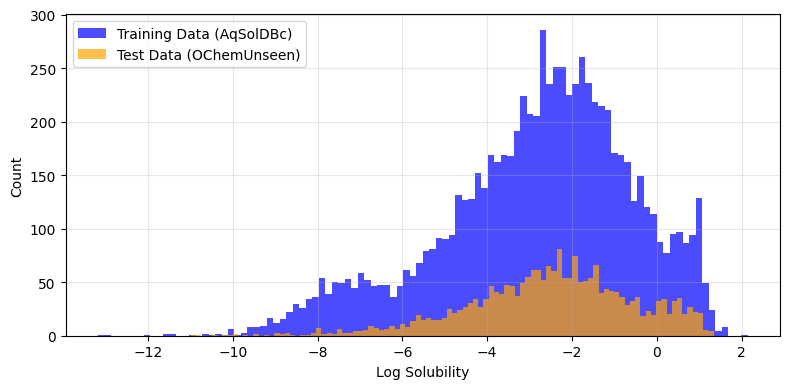

In [40]:
solubility_histogram(data_df_updated, test_df_updated, save_plots=save_plots)


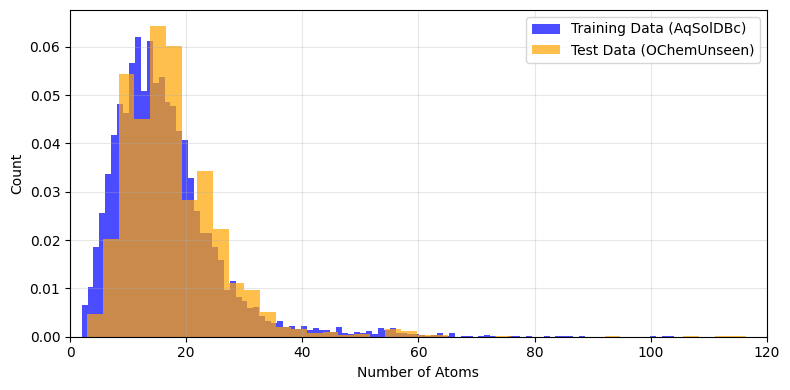

In [41]:
atom_count_histogram(data_df_updated, test_df_updated, save_plots=save_plots)

d:\Philipp\Studium\Molecular-Test-Time-Adaptation\utils\plot_utils.py:232: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


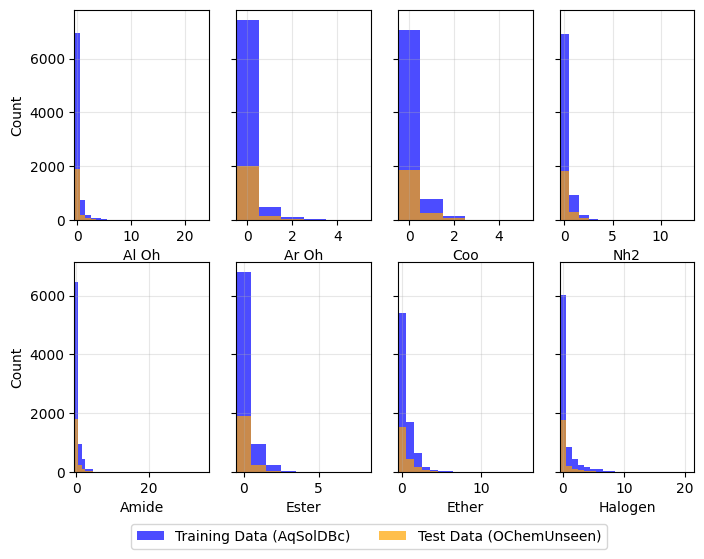

In [42]:
functional_group_histogram(data_df_updated, test_df_updated, save_plots=save_plots)

### Creating a distribution shift

In [43]:
print(f"Dataset size before filtering: {len(data_df_updated)}, {len(test_df_updated)}")

data_df_filtered = data_df_updated[
    (data_df_updated["num_atoms"] < 20)
    & ((data_df_updated["fr_ether"] == 0) & (data_df_updated["fr_NH2"] == 0))
]
test_df_filtered_eth = test_df_updated[
    (test_df_updated["num_atoms"] >= 20) & (test_df_updated["fr_ether"] > 0)
]
test_df_filtered_nh = test_df_updated[
    (test_df_updated["num_atoms"] >= 20) & (test_df_updated["fr_NH2"] > 0)
]

# We are increasing the already existing distribution shift between the train and test sets by filtering for atom counts and functional groups
# The train and validation sets will contain molecules with less than 20 atoms and no ether or NH2 functional groups
# The first test set will contain molecules with more than 20 atoms and ether functional groups
# The second test set will contain molecules with more than 20 atoms and NH2 functional groups

print(
    f"Dataset size after filtering: {len(data_df_filtered)}, {len(test_df_filtered_eth)}, {len(test_df_filtered_nh)}"
)

Dataset size before filtering: 8047, 2251
Dataset size after filtering: 3427, 258, 153


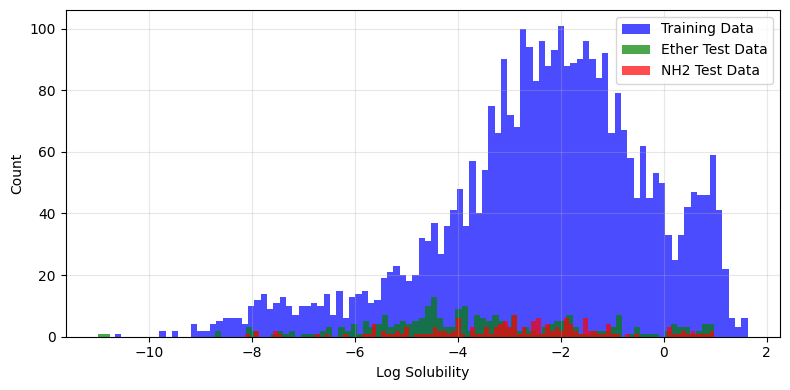

In [44]:
solubility_histogram_shift(data_df_filtered, test_df_filtered_eth, test_df_filtered_nh, save_plots=save_plots)

# Training

In [45]:
train_df, val_df = train_test_split(data_df_filtered, test_size=0.1, random_state=0)
train_loader = construct_loader(
    train_df, "SmilesCurated", "ExperimentalLogS", shuffle=True, batch_size=batch_size
)

val_loader = construct_loader(
    val_df, "SmilesCurated", "ExperimentalLogS", shuffle=False, batch_size=batch_size
)

test_loader_eth = construct_loader(
    test_df_filtered_eth, "SMILES", "LogS", shuffle=False, batch_size=1
)
test_loader_nh = construct_loader(
    test_df_filtered_nh, "SMILES", "LogS", shuffle=False, batch_size=1
)
print(
    f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size Ether: {len(test_loader_eth.dataset)}, Test size NH2: {len(test_loader_nh.dataset)}"
)

# Standardizer for the solubility labels
mean = np.mean(train_loader.dataset.labels)
std = np.std(train_loader.dataset.labels)
stdzer = Standardizer(mean, std)

Precomputing data...
Precomputation finished. 3084 molecules cached.
Precomputing data...
Precomputation finished. 343 molecules cached.
Precomputing data...
Precomputation finished. 258 molecules cached.
Precomputing data...
Precomputation finished. 153 molecules cached.
Train size: 3084, Val size: 343, Test size Ether: 258, Test size NH2: 153


### Hyperparameter optimization

In [46]:
# Optional hyperparameter optimization on the validation set

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    # Weighting the losses of the two tasks
    alpha = trial.suggest_float("alpha", 0.3, 0.6, step=0.1)  
    # Size of the encoder-decoder bottleneck
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32])  
    depth = trial.suggest_categorical("depth", [2, 3, 4, 5])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3, 0.4])
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-4, log=True)

    model = GNN(
        train_loader.dataset.num_node_features,
        train_loader.dataset.num_edge_features,
        hidden_size=hidden_size,
        depth=depth,
        dropout=dropout,
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    loss = nn.MSELoss(reduction="mean")

    # By default, we train for a fourth of the epochs used in the main training to get a rough estimate
    for epoch in range(epochs // 2):
        train_epoch(model, train_loader, optimizer, loss, alpha, stdzer)

        preds = pred(model, val_loader, mode="predict", stdzer=stdzer)
        rmse_pred = root_mean_squared_error(preds, val_loader.dataset.labels)

        trial.report(rmse_pred, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return rmse_pred

In [47]:
# Takes about half an hour on my machine for a setting of 20 epochs
if train_hyperparam_opt:
    study = optuna.create_study(
        direction="minimize",
        pruner=optuna.pruners.HyperbandPruner(),
        study_name="hyperparam_opt",
    )
    
    study.optimize(objective, n_trials=80, n_jobs=4)

    print(f"Best learning rate: {study.best_params['learning_rate']:.4f}")
    print(f"Best alpha: {study.best_params['alpha']:.4f}")
    print(f"Best hidden size: {study.best_params['hidden_size']:.4f}")
    print(f"Best depth: {study.best_params['depth']:.4f}")
    print(f"Best dropout: {study.best_params['dropout']:.4f}")
    print(f"Best weight decay: {study.best_params['weight_decay']:.4f}")

    study_results = study.trials_dataframe()
    study_results.to_csv("data/hyperparam_opt.csv", index=False)
    print("Study results saved to hyperparam_opt.csv")

    learning_rate = study.best_params["learning_rate"]
    alpha = study.best_params["alpha"]
    hidden_size = study.best_params["hidden_size"]
    depth = study.best_params["depth"]
    dropout = study.best_params["dropout"]
    weight_decay = study.best_params["weight_decay"]

    torch.cuda.empty_cache()

# Standard hyperparameters are the result of a previous hyperparameter optimization
else:
    learning_rate = 0.0063
    alpha = 0.4  # Weighting the losses of the two tasks, smaller alpha means less weight on the denoising task
    hidden_size = 32
    depth = 4
    dropout = 0.1
    weight_decay = 2.02e-06

### Training on both Tasks

In [48]:
model = GNN(
    train_loader.dataset.num_node_features,
    train_loader.dataset.num_edge_features,
    hidden_size=hidden_size,
    depth=depth,
    dropout=dropout,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

loss = nn.MSELoss(reduction="mean")
print("\n", model, "\n")


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=32, bias=True)
    (convs): ModuleList(
      (0-3): 4 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=76, out_features=32, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=32, out_features=32, bias=True)
    (ffn2): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (node_lin): Linear(in_features=32, out_features=44, bias=True)
    (edge_lin): Linear(in_features=32, out_features=7, bias=True)
  )
) 



In [49]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path))
    best_model = deepcopy(model).to(device)
    # Skip training
    epochs = 0

Loading model from trained_models\model.pt


In [50]:
# Training the model on both tasks simultaneously
if not load_trained_model:
    best_model = deepcopy(model).to(device)
    best_combined_val_loss = 1e5

    combined_train_loss_list = []
    denoise_train_loss_list = []
    pred_train_loss_list = []

    combined_val_loss_list = []
    denoise_val_loss_list = []
    pred_val_loss_list = []

    if epochs == 0:
        print("Skipping training, previously trained model was loaded.")

    for epoch in range(0, epochs):
        combined_train_loss, denoise_train_loss, pred_train_loss = train_epoch(
            model, train_loader, optimizer, loss, alpha=alpha, stdzer=stdzer
        )

        denoised = pred(model, val_loader, mode="denoise", stdzer=stdzer)
        node_feature_targets = [
            feature
            for batch in val_loader
            for feature in batch.x.cpu().flatten().tolist()
        ]
        
        edge_feature_targets = [
            feature
            for batch in val_loader
            for feature in batch.edge_attr.cpu().flatten().tolist()
        ]

        denoise_val_loss = root_mean_squared_error(
            denoised, node_feature_targets + edge_feature_targets
        )

        preds = pred(model, val_loader, mode="predict", stdzer=stdzer)
        pred_val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)
        combined_val_loss = alpha * denoise_val_loss + (1 - alpha) * pred_val_loss

        print(
            f"Epoch {epoch}  Train Combined Loss: {combined_train_loss:.3f}  Train Denoise Loss: {denoise_train_loss:.3f}  Train Pred Loss: {pred_train_loss:.3f}  Val Combined Loss: {combined_val_loss:.3f}  Val Denoise Loss: {denoise_val_loss:.3f}  Val Pred Loss: {pred_val_loss:.3f}"
        )

        combined_train_loss_list.append(combined_train_loss)
        denoise_train_loss_list.append(denoise_train_loss)
        pred_train_loss_list.append(pred_train_loss)
        denoise_val_loss_list.append(denoise_val_loss)
        pred_val_loss_list.append(pred_val_loss)
        combined_val_loss_list.append(combined_val_loss)


        if combined_val_loss < best_combined_val_loss:
            best_model = deepcopy(model).to(device)
            best_combined_val_loss = combined_val_loss

            # Save the best model
            if save_model:
                print(f"Saving best model based on combined Val Loss...")
                torch.save(
                    best_model.state_dict(), os.path.join("trained_models", f"model.pt")
                )

In [51]:
# Only plot if actual training was done
if epochs != 0:

    def normalize_losses(loss_list):
        # Normalize losses to [0, 1]
        min_val, max_val = min(loss_list), max(loss_list)
        return [(loss - min_val) / (max_val - min_val) for loss in loss_list]

    combined_train_loss_list_norm = normalize_losses(combined_train_loss_list)
    denoise_train_loss_list_norm = normalize_losses(denoise_train_loss_list)
    pred_train_loss_list_norm = normalize_losses(pred_train_loss_list)
    combined_val_loss_list_norm = normalize_losses(combined_val_loss_list)
    denoise_val_loss_list_norm = normalize_losses(denoise_val_loss_list)
    pred_val_loss_list_norm = normalize_losses(pred_val_loss_list)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Plot normalized losses
    ax.plot(
        list(range(epochs)),
        combined_train_loss_list_norm,
        label="Combined Train Loss",
        color="blue",
    )
    ax.plot(
        list(range(epochs)),
        denoise_train_loss_list_norm,
        label="Denoise Train Loss",
        color="orange",
    )
    ax.plot(
        list(range(epochs)),
        pred_train_loss_list_norm,
        label="Pred Train Loss",
        color="green",
    )
    ax.plot(
        list(range(epochs)),
        combined_val_loss_list_norm,
        label="Combined Val Loss",
        color="blue",
        linestyle="dashed",
    )
    ax.plot(
        list(range(epochs)),
        denoise_val_loss_list_norm,
        label="Denoise Val Loss",
        color="orange",
        linestyle="dashed",
    )
    ax.plot(
        list(range(epochs)),
        pred_val_loss_list_norm,
        label="Pred Val Loss",
        color="green",
        linestyle="dashed",
    )
    
    ax.legend(ncol=2)
    ax.set_xlabel("Epochs")
    ax.set_xticks(list(range(0, epochs, 5)))
    ax.set_ylabel("Normalized Loss")

    plt.tight_layout()
    if save_plots:
        plt.savefig("figures/loss_plot.jpg", dpi=300, bbox_inches="tight")
        plt.savefig("figures/loss_plot.pdf", bbox_inches="tight")
    plt.show()

### Training without SSL for reference

In [52]:
model_non_SSL = GNN(
    train_loader.dataset.num_node_features,
    train_loader.dataset.num_edge_features,
    hidden_size=hidden_size,
    depth=depth,
    dropout=dropout,
).to(device)

optimizer_non_SSL = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

loss_non_SSL = nn.MSELoss(reduction="mean")
print("\n", model, "\n")


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=32, bias=True)
    (convs): ModuleList(
      (0-3): 4 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=76, out_features=32, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=32, out_features=32, bias=True)
    (ffn2): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (node_lin): Linear(in_features=32, out_features=44, bias=True)
    (edge_lin): Linear(in_features=32, out_features=7, bias=True)
  )
) 



In [53]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model_non_SSL.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model_non_SSL.load_state_dict(torch.load(model_path))
    best_model_non_SSL = deepcopy(model_non_SSL).to(device)
    # Skip training
    epochs = 0

Loading model from trained_models\model_non_SSL.pt


In [54]:
best_model_non_SSL = deepcopy(model_non_SSL).to(device)
best_val_loss = 1e5

train_loss_list = []
val_loss_list = []

if epochs == 0:
    print("Skipping training, previously trained model was loaded.")

for epoch in range(0, epochs):
    train_loss = train_epoch_without_SSL(
        model_non_SSL,
        train_loader,
        optimizer_non_SSL,
        loss_non_SSL,
        alpha=alpha,
        stdzer=stdzer,
    )

    preds = pred(model_non_SSL, val_loader, mode="predict", stdzer=stdzer)
    val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.2f}  Val Loss: {val_loss:.2f}")

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_model_non_SSL = deepcopy(model_non_SSL).to(device)
        best_val_loss = val_loss

        # Save the best model
        if save_model:
            print(f"Saving best model based on Val Loss...")
            torch.save(
                best_model_non_SSL.state_dict(),
                os.path.join("trained_models", f"model_non_SSL.pt"),
            )

Skipping training, previously trained model was loaded.


# Prediction

In [64]:
learning_rate_TTA = learning_rate
# Set the learning rate for TTA to be the same as the original learning rate
# Tried optimizing it on the validation set, but it did not change the results significantly

In [65]:
# Prediction with non-SSL model
val_preds_non_SSL = pred(best_model_non_SSL, val_loader, mode="predict", stdzer=stdzer)
test_preds_non_SSL_eth = pred(
    best_model_non_SSL, test_loader_eth, mode="predict", stdzer=stdzer
)
test_preds_non_SSL_nh = pred(
    best_model_non_SSL, test_loader_nh, mode="predict", stdzer=stdzer
)

print("Reference results for model trained without SSL:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds_non_SSL, val_loader.dataset.labels):.4f}"
)
print(
    f"Ether Test Set RMSE: {root_mean_squared_error(test_preds_non_SSL_eth, test_loader_eth.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_non_SSL_nh, test_loader_nh.dataset.labels):.4f}"
)

Reference results for model trained without SSL:
Val Set RMSE: 2.4191
Ether Test Set RMSE: 4.8271
NH2 Test Set RMSE: 4.1739


In [66]:
# Prediction with SLL model without TTA
val_preds = pred(best_model, val_loader, mode="predict", stdzer=stdzer)
test_preds_eth = pred(best_model, test_loader_eth, mode="predict", stdzer=stdzer)
test_preds_nh = pred(best_model, test_loader_nh, mode="predict", stdzer=stdzer)

print("Results without TTA:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds, val_loader.dataset.labels):.4f}"
)
print(
    f"Ether Test Set RMSE: {root_mean_squared_error(test_preds_eth, test_loader_eth.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_nh, test_loader_nh.dataset.labels):.4f}"
)

Results without TTA:
Val Set RMSE: 1.0703
Ether Test Set RMSE: 2.2809
NH2 Test Set RMSE: 2.3771


In [67]:
# Prediction with SLL model with TTA
# Takes about three times as long as prediction without TTA
val_preds_TTA = pred_with_TTA(
    best_model, val_loader, lr=learning_rate_TTA, stdzer=stdzer
)
test_preds_TTA_eth = pred_with_TTA(
    best_model, test_loader_eth, lr=learning_rate_TTA, stdzer=stdzer
)
test_preds_TTA_nh = pred_with_TTA(
    best_model, test_loader_nh, lr=learning_rate_TTA, stdzer=stdzer
)

print("Results on with TTA:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds_TTA, val_loader.dataset.labels):.4f}"
)
print(
    f"Ether Test Set RMSE: {root_mean_squared_error(test_preds_TTA_eth, test_loader_eth.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_TTA_nh, test_loader_nh.dataset.labels):.4f}"
)

Results on with TTA:
Val Set RMSE: 1.1602
Ether Test Set RMSE: 2.2809
NH2 Test Set RMSE: 2.3775


# Analysis

### Getting the Embeddings

In [68]:
best_model = best_model.to(device)

# The embeddings are lists of length "samples" of vectors with length "hidden_size"
train_embeddings = []
for batch in train_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    train_embeddings.extend(embedding.cpu().detach().numpy())

val_embeddings = []
for batch in val_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    val_embeddings.extend(embedding.cpu().detach().numpy())

test_embeddings_eth = []
for batch in test_loader_eth:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    test_embeddings_eth.extend(embedding.cpu().detach().numpy())

test_embeddings_nh = []
for batch in test_loader_nh:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    test_embeddings_nh.extend(embedding.cpu().detach().numpy())

# Combine all embeddings for t-SNE fitting
all_embeddings = np.vstack(
    [train_embeddings, val_embeddings, test_embeddings_eth, test_embeddings_nh]
)

In [69]:
# Create and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
all_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Split back into individual datasets
train_size = len(train_embeddings)
val_size = len(val_embeddings)
test_size_eth = len(test_embeddings_eth)
test_size_nh = len(test_embeddings_nh)

train_embeddings_tsne = all_embeddings_tsne[:train_size]
val_embeddings_tsne = all_embeddings_tsne[train_size : train_size + val_size]
test_embeddings_tsne_eth = all_embeddings_tsne[
    train_size + val_size : train_size + val_size + test_size_eth
]
test_embeddings_tsne_nh = all_embeddings_tsne[train_size + val_size + test_size_eth :]

# Create and fit UMAP for 2D projections
umap_reducer = UMAP(
    n_components=2,
)
all_embeddings_umap = umap_reducer.fit_transform(all_embeddings, n_jobs=-1)

# Split UMAP results back into individual datasets
train_embeddings_umap = all_embeddings_umap[:train_size]
val_embeddings_umap = all_embeddings_umap[train_size : train_size + val_size]
test_embeddings_umap_eth = all_embeddings_umap[
    train_size + val_size : train_size + val_size + test_size_eth
]
test_embeddings_umap_nh = all_embeddings_umap[train_size + val_size + test_size_eth :]

# Also getting the test set embeddings after TTA
test_embeddings_with_TTA_eth = embeddings_with_TTA(
    best_model, test_loader_eth, lr=learning_rate_TTA
)
test_embeddings_with_TTA_nh = embeddings_with_TTA(
    best_model, test_loader_nh, lr=learning_rate_TTA
)

test_embeddings_with_TTA_tsne_eth = tsne.fit_transform(
    np.array(test_embeddings_with_TTA_eth)
)
test_embeddings_with_TTA_umap_eth = umap_reducer.transform(
    np.array(test_embeddings_with_TTA_eth)
)

test_embeddings_with_TTA_tsne_nh = tsne.fit_transform(
    np.array(test_embeddings_with_TTA_nh)
)
test_embeddings_with_TTA_umap_nh = umap_reducer.transform(
    np.array(test_embeddings_with_TTA_nh)
)

# Get the solubility values from each dataset
train_solubility = train_loader.dataset.labels
val_solubility = val_loader.dataset.labels
test_solubility_eth = test_loader_eth.dataset.labels
test_solubility_nh = test_loader_nh.dataset.labels

### Analyzing the Solubility Distribution

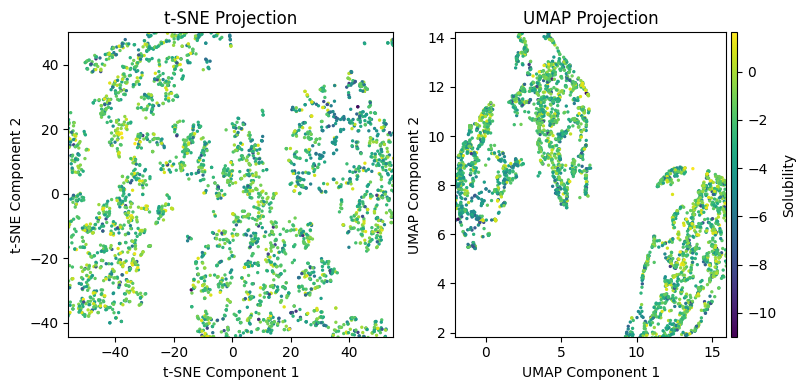

In [70]:
solubility_embeddings(
    train_solubility,
    val_solubility,
    test_solubility_eth,
    test_solubility_nh,
    train_embeddings_tsne,
    val_embeddings_tsne,
    test_embeddings_tsne_eth,
    test_embeddings_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    test_embeddings_umap_eth,
    test_embeddings_umap_nh,
    save_plots=save_plots,
)

### Analyzing the Class Distribution and Effect of TTA

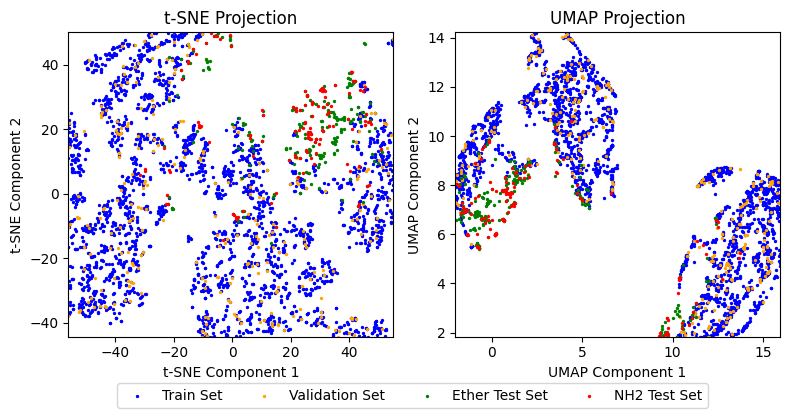

In [74]:
sets_embeddings(
    train_embeddings_tsne,
    val_embeddings_tsne,
    test_embeddings_tsne_eth,
    test_embeddings_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    test_embeddings_umap_eth,
    test_embeddings_umap_nh,
    save_plots=save_plots,
)

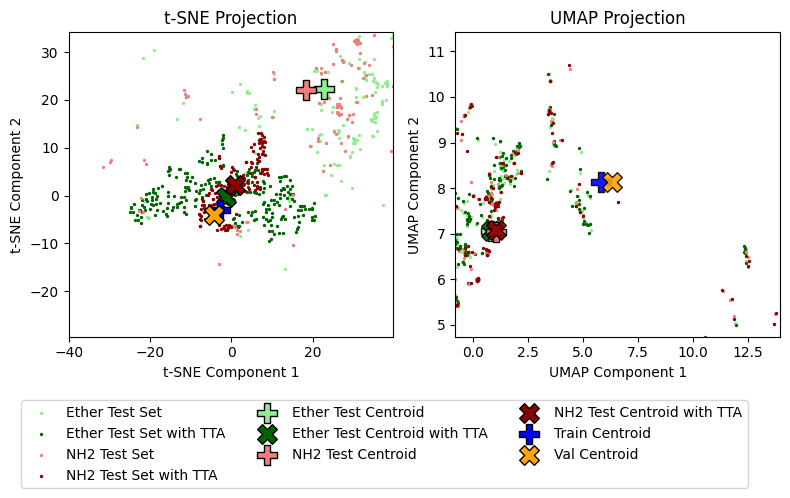

In [79]:
centroid_embeddings(
    train_embeddings_tsne,
    val_embeddings_tsne,
    test_embeddings_tsne_eth,
    test_embeddings_tsne_nh,
    test_embeddings_with_TTA_tsne_eth,
    test_embeddings_with_TTA_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    test_embeddings_umap_eth,
    test_embeddings_umap_nh,
    test_embeddings_with_TTA_umap_eth,
    test_embeddings_with_TTA_umap_nh,
    save_plots=save_plots,
)